## Plot Spectrograms

In [1]:
import torch
import torchaudio
import numpy as np
from scipy.signal import stft
import librosa
import matplotlib.pyplot as plt

def plot_spectrograms(original_path: str, enhanced_path: str, sr: int = 44100):
    # Load audio files
    original, orig_sr = torchaudio.load(original_path)
    enhanced, enh_sr = torchaudio.load(enhanced_path)

    # Convert to mono if stereo
    if original.shape[0] > 1:
        original = torch.mean(original, dim=0)
    if enhanced.shape[0] > 1:
        enhanced = torch.mean(enhanced, dim=0)

    # Resample if necessary
    if orig_sr != sr:
        original = torchaudio.transforms.Resample(orig_sr, sr)(original)
    if enh_sr != sr:
        enhanced = torchaudio.transforms.Resample(enh_sr, sr)(enhanced)

    # Convert to numpy and ensure 1D
    original = original.numpy().squeeze()
    enhanced = enhanced.numpy().squeeze()

    # Create spectrograms
    n_fft = 2048
    hop_length = 512
    win_length = n_fft

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot original spectrogram
    S_original = librosa.stft(original, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')
    D_original = librosa.amplitude_to_db(np.abs(S_original), ref=np.max)
    img1 = librosa.display.specshow(D_original, y_axis='log', x_axis='time',
                                  sr=sr, hop_length=hop_length, ax=axs[0])
    axs[0].set_title('Original Audio Spectrogram')
    fig.colorbar(img1, ax=axs[0], format='%+2.0f dB')

    # Plot enhanced spectrogram
    S_enhanced = librosa.stft(enhanced, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann')
    D_enhanced = librosa.amplitude_to_db(np.abs(S_enhanced), ref=np.max)
    img2 = librosa.display.specshow(D_enhanced, y_axis='log', x_axis='time',
                                  sr=sr, hop_length=hop_length, ax=axs[1])
    axs[1].set_title('Enhanced Audio Spectrogram')
    fig.colorbar(img2, ax=axs[1], format='%+2.0f dB')

    plt.tight_layout()
    plt.show()



## Spectrograms Original vs. Upsampled

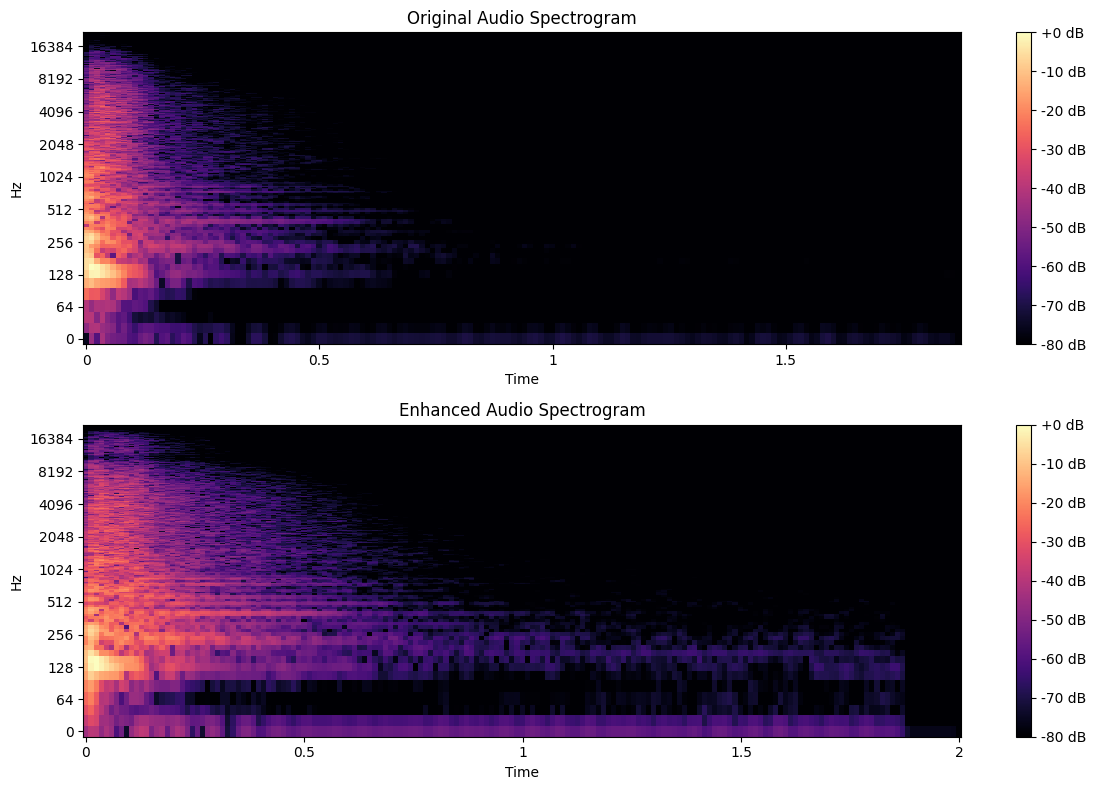

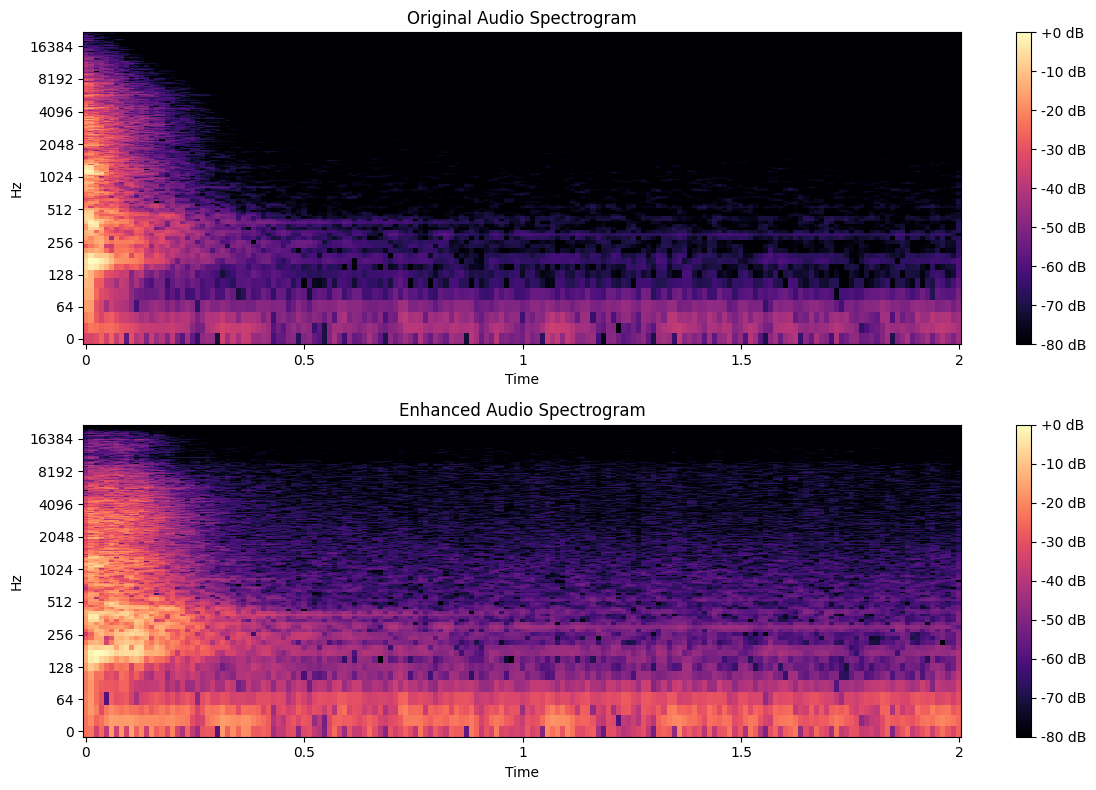

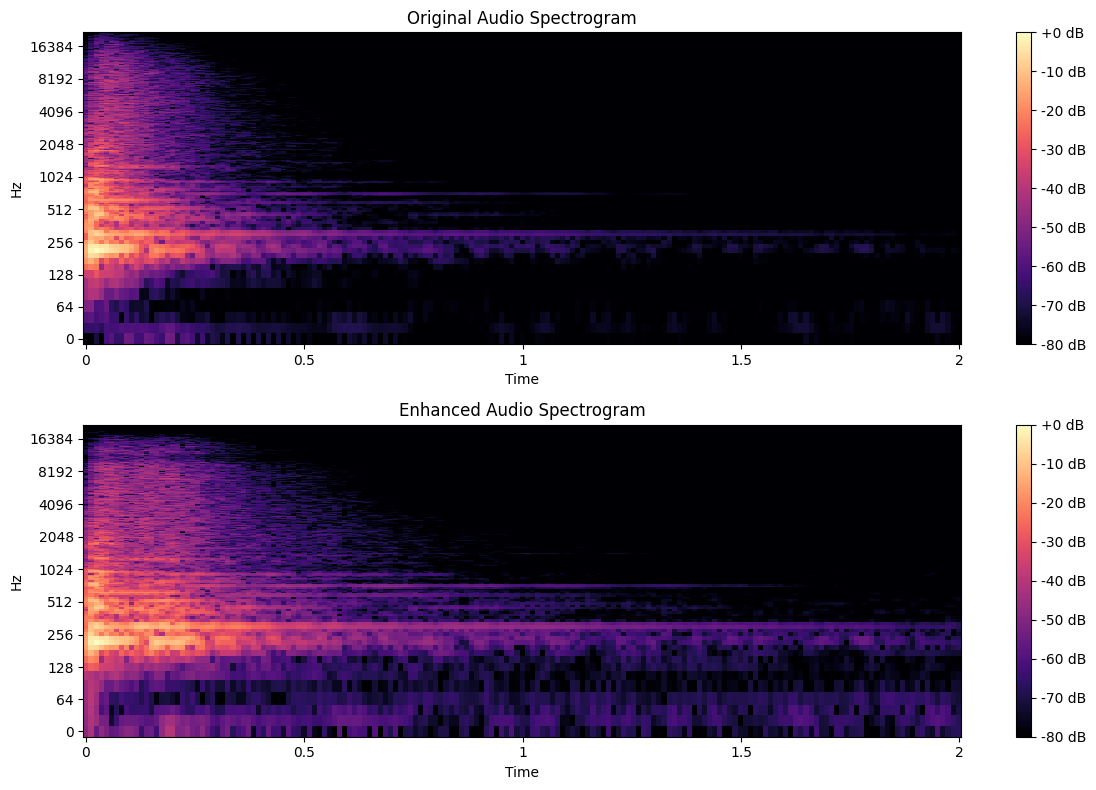

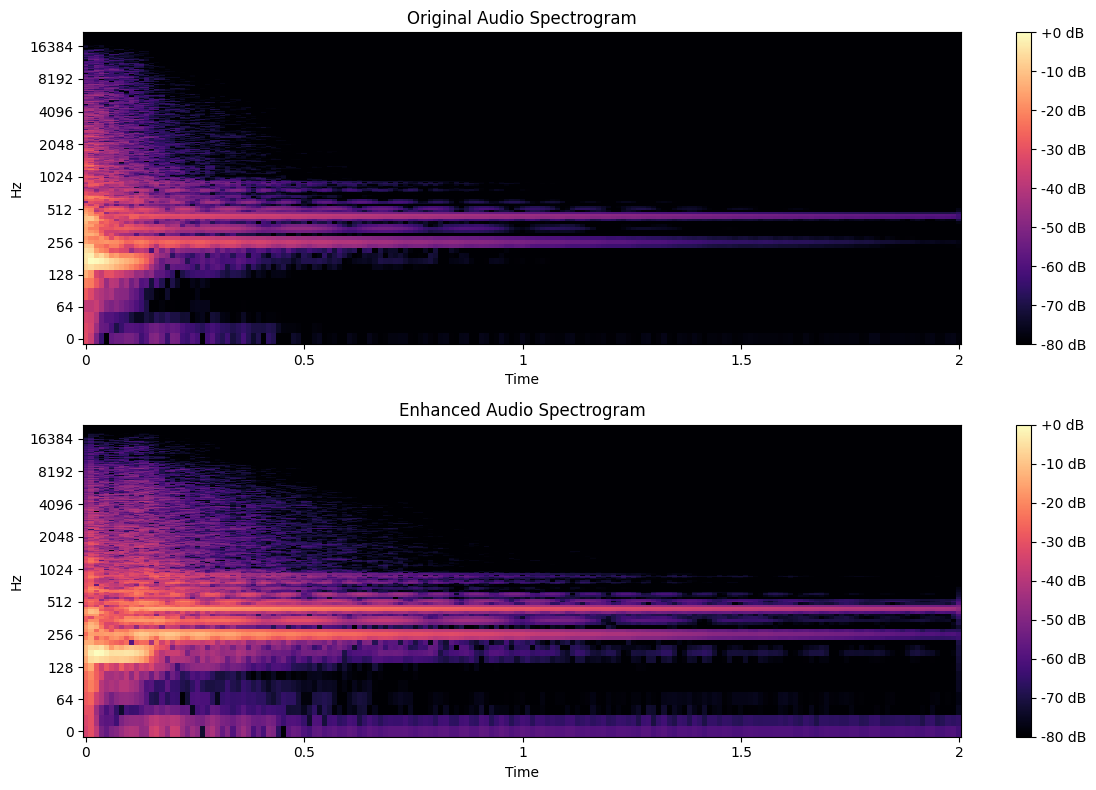

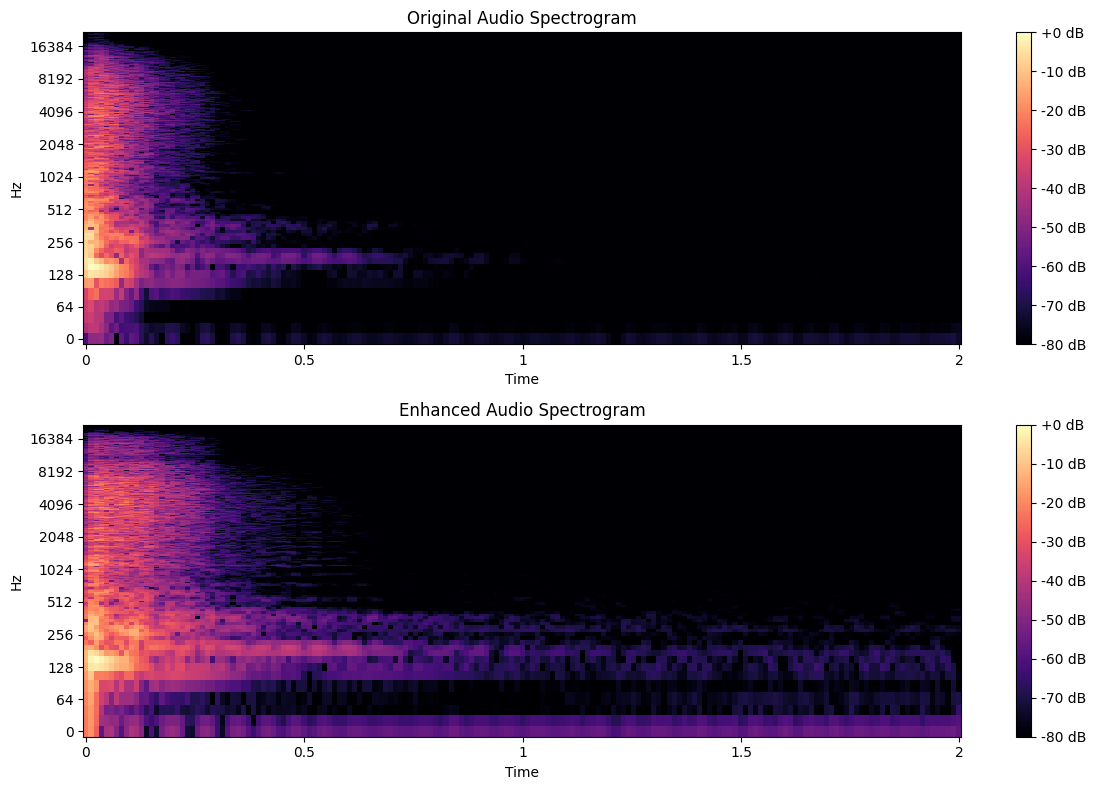

In [2]:
for i in range(1,6):
  try:
      plot_spectrograms(
          original_path=f"sample{i}_hr.wav",
          enhanced_path=f"sample{i}_upsampled.wav"
      )
  except Exception as e:
      print(f"Error occurred: {str(e)}")
      print("\nPlease check if the audio files exist and are valid WAV files.")

## Spectrograms Low Resolution 22.05 kHz vs. Upsampled

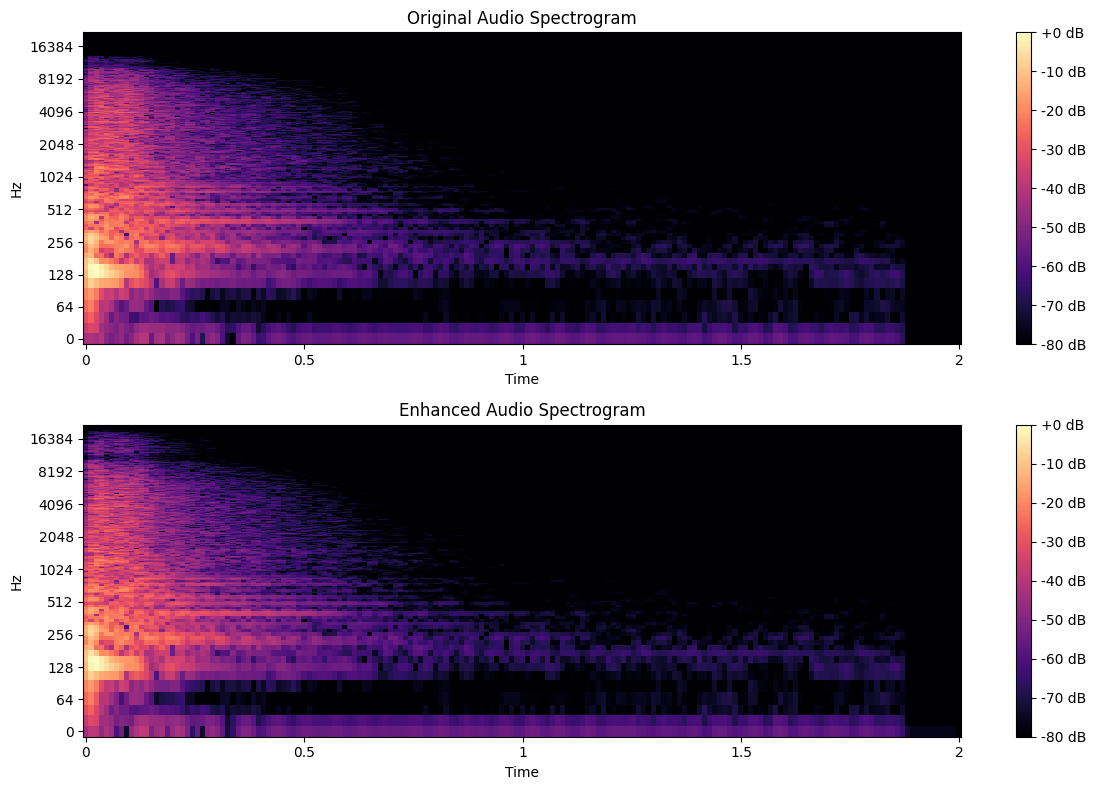

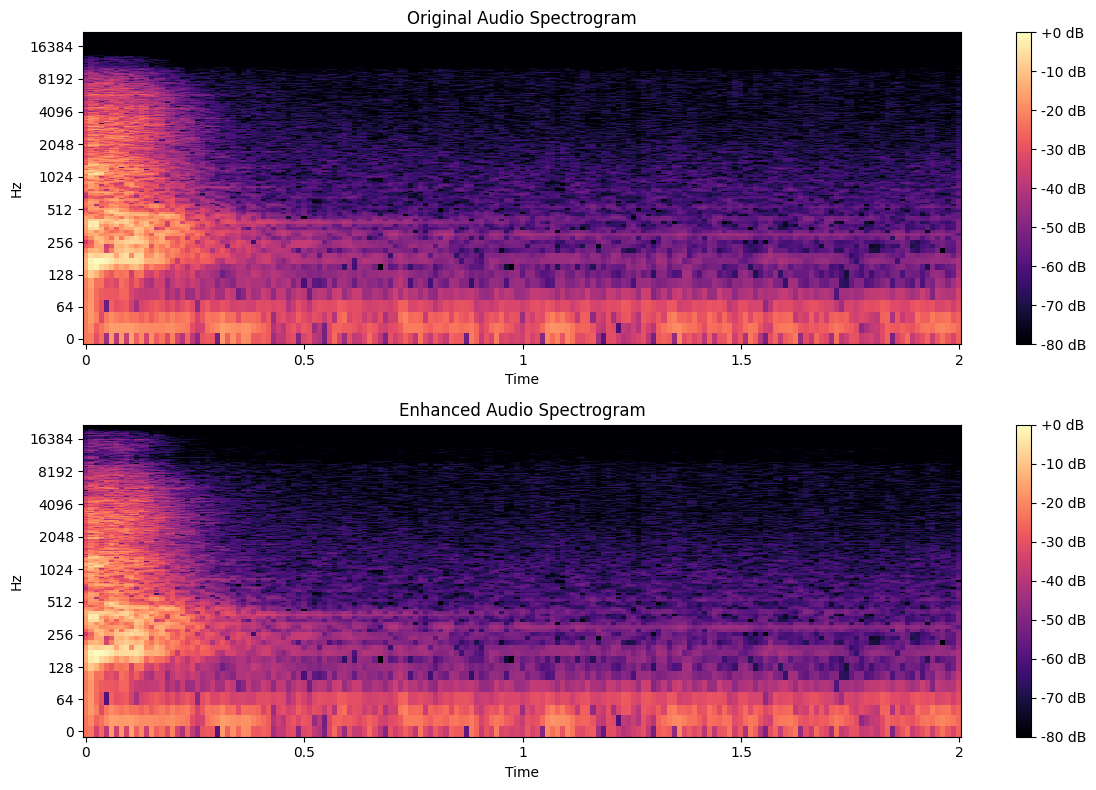

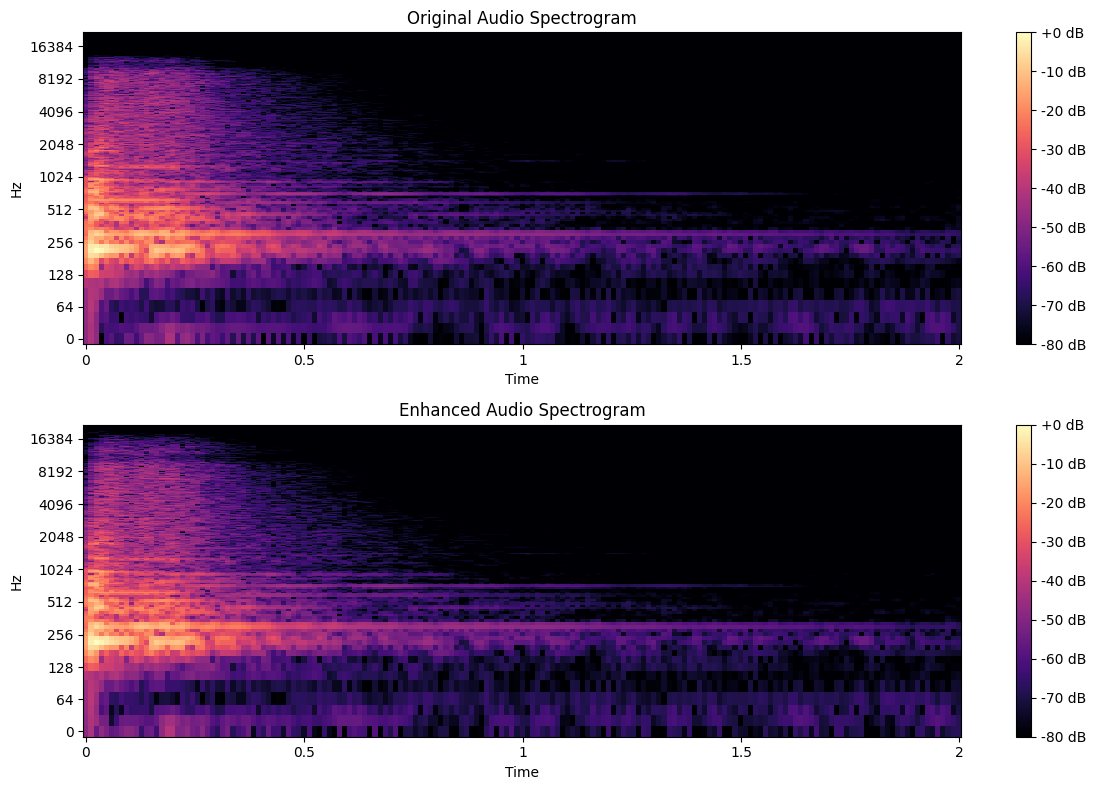

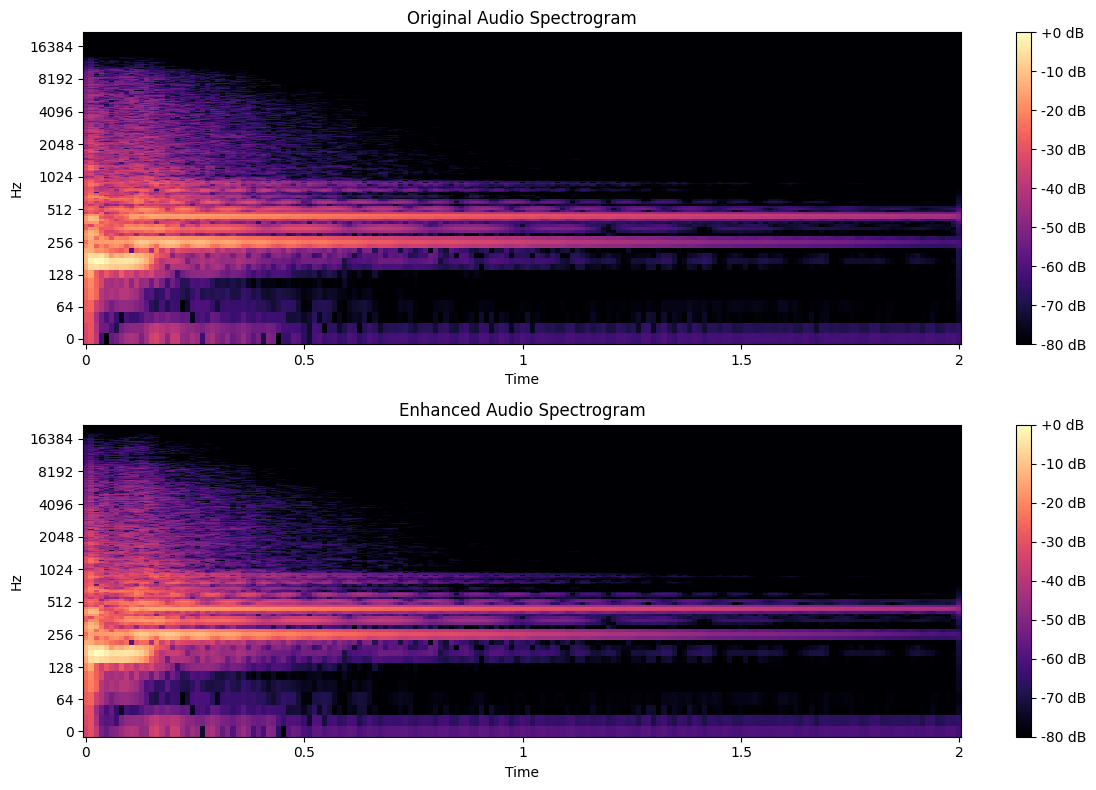

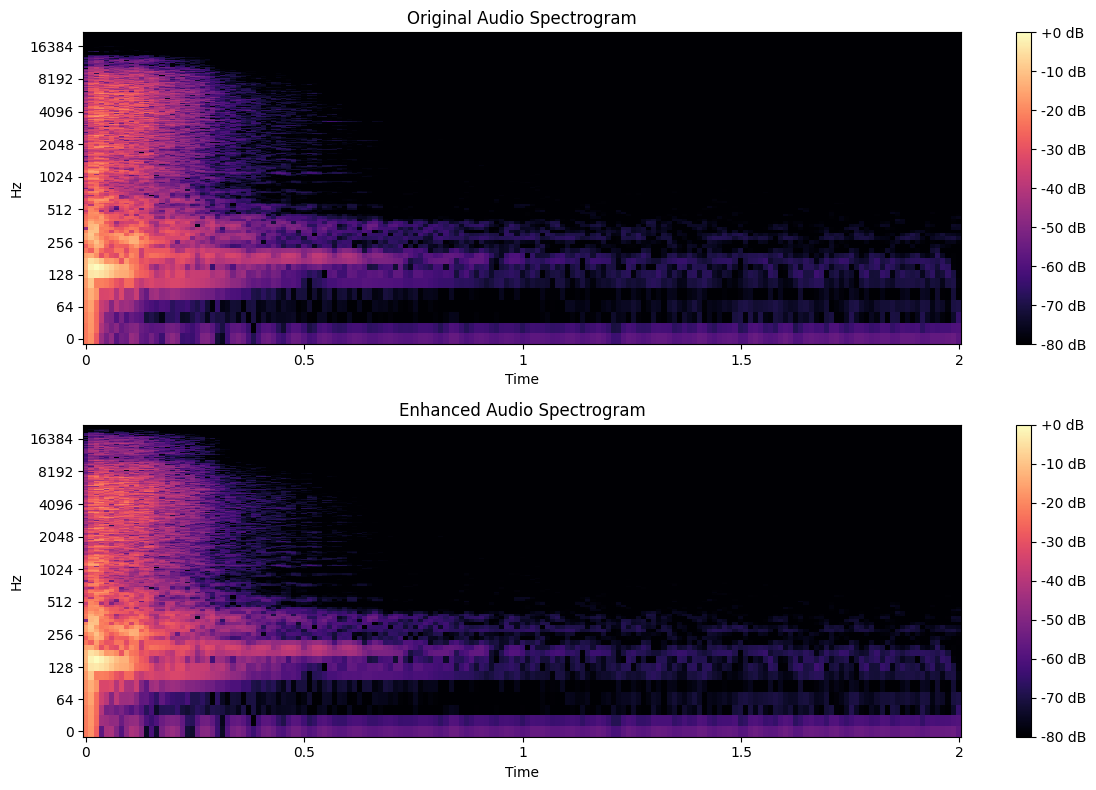

In [3]:
for i in range(1,6):
  try:
      plot_spectrograms(
          original_path=f"sample{i}_lr.wav",
          enhanced_path=f"sample{i}_upsampled.wav"
      )
  except Exception as e:
      print(f"Error occurred: {str(e)}")
      print("\nPlease check if the audio files exist and are valid WAV files.")

## Audio Quality Metrics - MCD, LSD

In [4]:
import torch
import torchaudio
import numpy as np
from scipy.signal import stft
from scipy.linalg import sqrtm
import librosa
import warnings
warnings.filterwarnings('ignore')

class AudioQualityMetrics:
    def __init__(self, sr=44100, n_fft=2048, hop_length=512, n_mels=128):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels

    def log_spectral_distance(self, y_true, y_pred):
        """
        Compute Log Spectral Distance (LSD) between two signals.
        Lower is better.
        """
        # Compute STFTs
        D_true = librosa.stft(y_true, n_fft=self.n_fft, hop_length=self.hop_length)
        D_pred = librosa.stft(y_pred, n_fft=self.n_fft, hop_length=self.hop_length)

        # Compute log power spectrograms
        S_true = np.log10(np.abs(D_true)**2 + 1e-7)
        S_pred = np.log10(np.abs(D_pred)**2 + 1e-7)

        # Compute LSD with normalization
        lsd = np.sqrt(np.mean((S_true - S_pred)**2, axis=0))
        lsd = np.mean(lsd) / (self.n_fft//2 + 1)

        return lsd

    def mel_cepstral_distance(self, y_true, y_pred):
        """
        Compute Mel Cepstral Distance (MCD) between two signals.
        Lower is better.
        """
        # Compute MFCCs (excluding 0th coefficient)
        mfcc_true = librosa.feature.mfcc(
            y=y_true,
            sr=self.sr,
            n_mfcc=13,  # typical value
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )[1:]  # exclude 0th coefficient

        mfcc_pred = librosa.feature.mfcc(
            y=y_pred,
            sr=self.sr,
            n_mfcc=13,
            n_fft=self.n_fft,
            hop_length=self.hop_length
        )[1:]

        # Compute MCD
        diff = mfcc_true - mfcc_pred
        mcd = np.sqrt(2 * np.sum(diff**2, axis=0))
        mcd = np.mean(mcd)

        return mcd

def evaluate_audio_quality(original_path, generated_path, metrics=None):
    if metrics is None:
        metrics = AudioQualityMetrics()

    # Load audio files
    y_true, sr = librosa.load(original_path, sr=44100)
    y_pred, sr = librosa.load(generated_path, sr=44100)

    # Ensure same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    # Calculate metrics
    results = {
        'log_spectral_distance': metrics.log_spectral_distance(y_true, y_pred),
        'mel_cepstral_distance': metrics.mel_cepstral_distance(y_true, y_pred),
    }

    return results

# Example usage
def print_quality_metrics(original_file, generated_file):
    """
    Print formatted quality metrics for audio comparison.
    """
    metrics = AudioQualityMetrics()
    results = evaluate_audio_quality(original_file, generated_file, metrics)

    print("\nAudio Quality Metrics:")
    print("-" * 50)
    print(f"Log Spectral Distance (LSD): {results['log_spectral_distance']:.4f}")
    print(f"Mel Cepstral Distance (MCD): {results['mel_cepstral_distance']:.4f}")
    print("-" * 50)

# print_quality_metrics("original_audio_hr.wav", "output.wav")

## Audio Quality Metrics for 5 random samples

In [5]:
for i in range(1,6):
  print_quality_metrics(f"sample{i}_hr.wav", f"sample{i}_upsampled.wav")


Audio Quality Metrics:
--------------------------------------------------
Log Spectral Distance (LSD): 0.0016
Mel Cepstral Distance (MCD): 56.5998
--------------------------------------------------

Audio Quality Metrics:
--------------------------------------------------
Log Spectral Distance (LSD): 0.0026
Mel Cepstral Distance (MCD): 93.5142
--------------------------------------------------

Audio Quality Metrics:
--------------------------------------------------
Log Spectral Distance (LSD): 0.0015
Mel Cepstral Distance (MCD): 57.0424
--------------------------------------------------

Audio Quality Metrics:
--------------------------------------------------
Log Spectral Distance (LSD): 0.0013
Mel Cepstral Distance (MCD): 80.8516
--------------------------------------------------

Audio Quality Metrics:
--------------------------------------------------
Log Spectral Distance (LSD): 0.0013
Mel Cepstral Distance (MCD): 50.5280
--------------------------------------------------
